# Fashion Recommendation System

## Embedding model - DenseNet

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
%matplotlib inline

In [12]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Sat Nov 27 02:13:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  5%   60C    P5    14W / 180W |   1165MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   58C    P8     6W / 180W |   8095MiB /  8119MiB |      0%      Default |
+-------------------------------+---------------

## Data Preprocessing

In [13]:
# Meta Data
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('/media/pavan/datasets/deepfashion/Anno/list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('/media/pavan/datasets/deepfashion/Anno/list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('/media/pavan/datasets/deepfashion/Eval/list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [14]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head()

,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,Blouse


In [15]:
len(data_df)

289222

In [16]:
data_df[['image_path','dataset_type']].groupby('dataset_type').count()

,image_path
dataset_type,
test,40000
train,209222
val,40000


In [17]:
len(data_df.category.unique())

46

In [18]:
data_df[['image_path','category']].groupby('category').count()

,image_path
category,
Anorak,160
Blazer,7495
Blouse,24557
Bomber,309
Button-Down,330
Caftan,54
Capris,77
Cardigan,13311
Chinos,527


# Convert images to embeddings

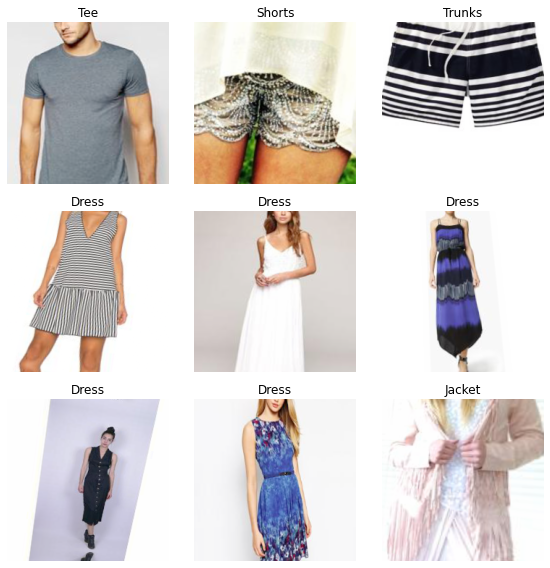

In [19]:
root_path = '/media/pavan/datasets/deepfashion/Img/'
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=64).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

## Conduct Transfer Learning from DenseNet

In [3]:
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.densenet121

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [21]:
learner.fit_one_cycle(10, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.533569,1.400900,0.587875,0.587875,0.890700,15:13
1,1.537566,1.434205,0.579175,0.579175,0.887025,15:16
2,1.545232,1.529948,0.564275,0.564275,0.877725,15:18
3,1.586443,1.458502,0.598500,0.598500,0.894575,15:17
4,1.509369,1.409913,0.602975,0.602975,0.895150,15:20
5,1.443534,1.311058,0.621500,0.621500,0.904425,15:18
6,1.372159,1.244659,0.634200,0.634200,0.914175,15:21
7,1.329115,1.203857,0.646800,0.646800,0.918675,15:20
8,1.289064,1.170284,0.658700,0.658700,0.922200,15:20
9,1.263016,1.161160,0.660000,0.660000,0.924525,15:22


## Evaluate Model 

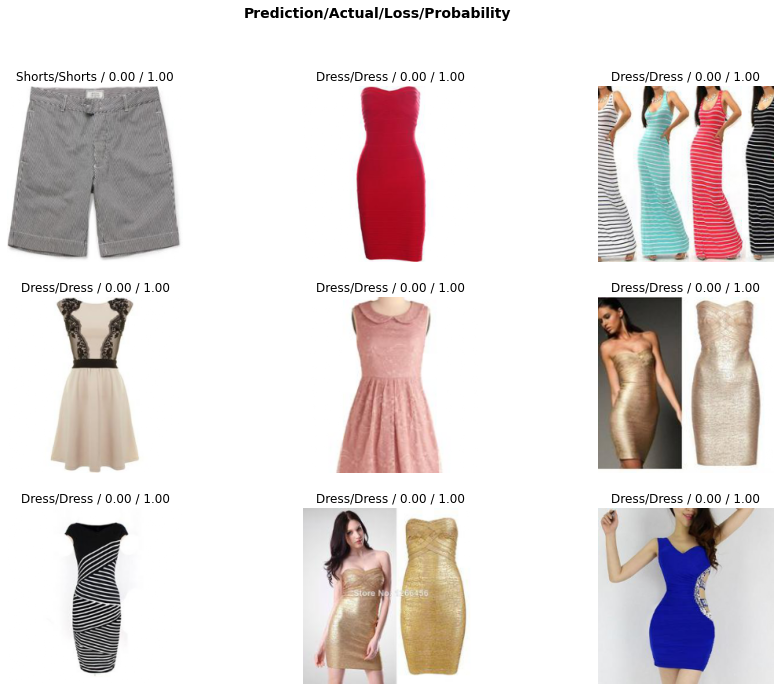

In [22]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

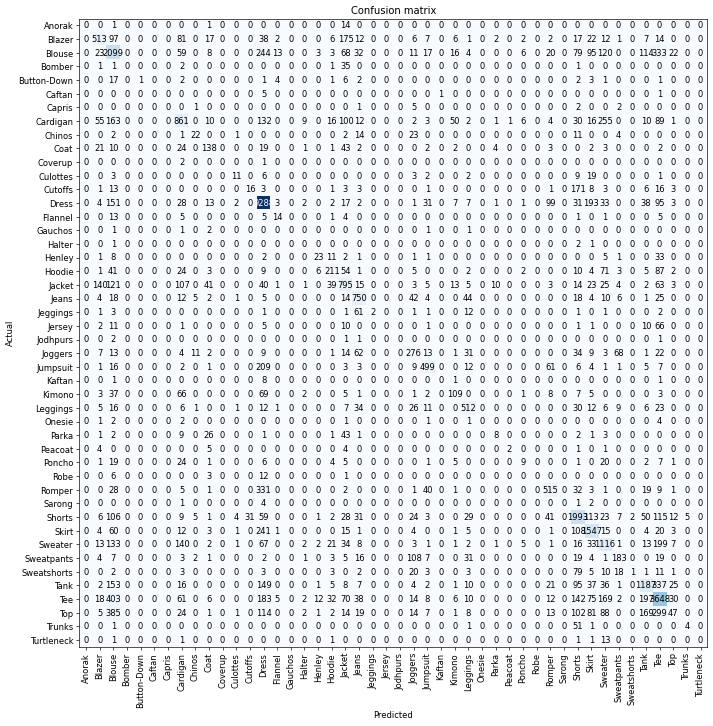

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
learner.save('/home/pavan/code/sjsu/256/project/densenet-fashion')

In [26]:
learner.model.module

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

# Use Fastai hooks to retrieve image embeddings

In [27]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [30]:
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.densenet121 

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]

model_path = "/home/pavan/code/sjsu/256/project/densenet-fashion"
loaded_learner = load_learner(data, pretrained_model, model_metrics, model_path)

In [31]:
loaded_learner.model.module[1][4]

Linear(in_features=2048, out_features=512, bias=True)

In [32]:
loaded_learner.model.module[-1][-3]

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [33]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(loaded_learner.model.module[-1][-3])
train_embed = loaded_learner.get_preds(data.train_ds)
val_embed = loaded_learner.get_preds(data.valid_ds)

In [38]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})[:len(saved_features.features)]
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

,img_path,label,label_id,embeddings
0,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[0.08576781302690506, -0.045043233782052994, 0..."
1,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[0.24445103108882904, -0.045043233782052994, 0..."
2,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[-0.029751017689704895, -0.045043233782052994,..."
3,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[0.18996287882328033, -0.045043233782052994, 0..."
4,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[0.0012712976895272732, -0.045043233782052994,..."
...,...,...,...,...
213089,/media/pavan/datasets/deepfashion/Img/img/Pint...,Blouse,2,"[-0.08240500092506409, 0.06518856436014175, -0..."
213090,/media/pavan/datasets/deepfashion/Img/img/Pint...,Blouse,2,"[-0.08240500092506409, 0.24264562129974365, -0..."
213091,/media/pavan/datasets/deepfashion/Img/img/Pint...,Blouse,2,"[-0.08240500092506409, 0.23482152819633484, -0..."
213092,/media/pavan/datasets/deepfashion/Img/img/Pint...,Blouse,2,"[-0.08240500092506409, 0.2043941468000412, -0...."


# Use Approximate Nearest Neighbors to obtain most similar images

In [39]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 

def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [40]:
# more tree = better approximation
ntree = 100
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

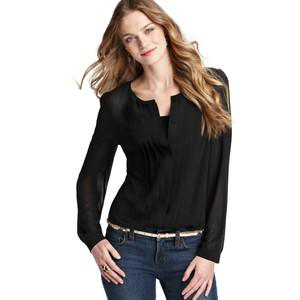

In [42]:
open_image(data_df_ouput.iloc[0, 0])

In [43]:
outfit_img_ids = [0]
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

_, _, similar_images_df = get_similar_images_annoy(annoy_tree, 0, 30)

1.125335693359375 ms


In [44]:
temp = similar_images_df[similar_images_df['label'] == 'Blouse']

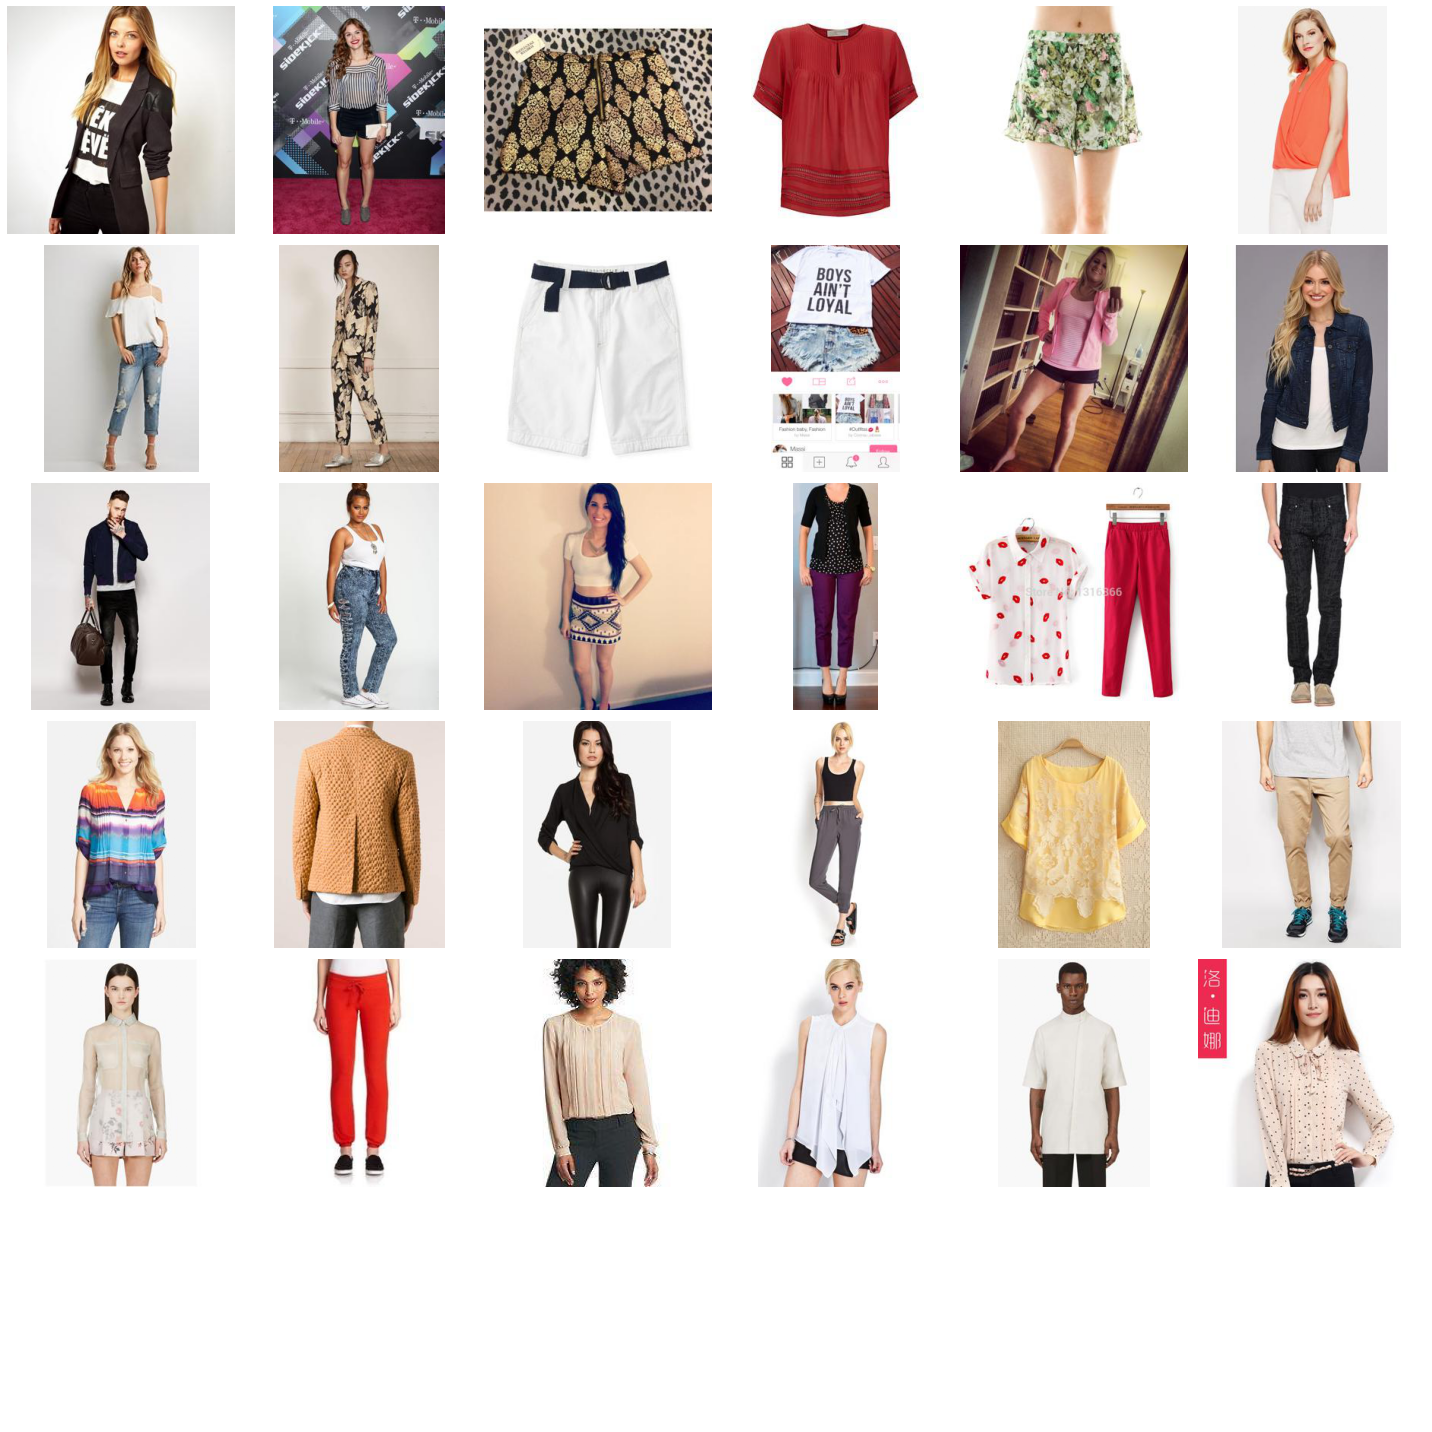

In [46]:
show_similar_images(similar_images_df, fig_size=[20,20])